In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import cv2
import torch
from peddet.data import PennFudanDataModule
from peddet.transforms import TrainTransforms, ValTransforms
%load_ext autoreload
%autoreload 2

# Visualization utils

In [ ]:
# colors
class Color:
    CYAN = (0,255,255)
    RED = (255,0,0)
    BLUE = (0,0,255)
    WHITE = (255,255,255)
    BLACK = (0,0,0)

def to_numpy(x:torch.Tensor,permute=False):
    if permute:
        x = x.permute(1,2,0)
    return x.cpu().detach().numpy()

def draw_boxes(image,boxes,labels=None,color=Color.WHITE,lw=2):
        if labels is None:
            labels = [''] * len(boxes)
        for bbox,label in zip(boxes,labels):
            x_min,y_min,x_max,y_max = bbox
            # Draw bounding box
            cv2.rectangle(
                image,
                (x_min,y_min),
                (x_max,y_max),
                color=color,
                thickness=lw
            )
            # Draw label
            ((text_width, text_height), _) = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, lw)
            cv2.rectangle(image, (x_min, y_min - int(1.5 * text_height)), (x_min + text_width + 1, y_min), color, -1)
            cv2.putText(
                image,
                text=label,
                org=(x_min + 1, y_min - int(0.3 * text_height)),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=0.5, 
                color=Color.BLACK,
                lineType=cv2.LINE_AA
            )

def show_record(image,
                boxes=None,
                labels=None,
                lw=2,
                form='pascal_voc',
                ax=None):
    img_copy = image.copy()
    if form=='coco':
        boxes[:,2] = boxes[:,0] + boxes[:,2]
        boxes[:,3] = boxes[:,1] + boxes[:,3]

    if boxes is not None:
        draw_boxes(img_copy,boxes,labels,color=Color.CYAN)
    
    if ax is None:
        return img_copy
    
    return ax.imshow(img_copy)

# Data prep

In [ ]:
fold = 2
df = pd.read_csv('data_with_folds.csv')
df[['x','y','x1','y1']] = pd.DataFrame(
    np.stack(df['box'].apply(ast.literal_eval)).astype(np.float32)
)

In [ ]:
train_df = df.loc[df['fold'] != fold].copy()
train_dataset = PennFudanDataset(train_df)
image,target,image_id = train_dataset[0]

In [ ]:
image,target,image_id

(array([[[0.827451  , 0.78431374, 0.7137255 ],
         [0.8235294 , 0.78039217, 0.70980394],
         [0.83137256, 0.7882353 , 0.7176471 ],
         ...,
         [0.56078434, 0.3764706 , 0.30588236],
         [0.57254905, 0.3882353 , 0.31764707],
         [0.5803922 , 0.39607844, 0.3254902 ]],
 
        [[0.7019608 , 0.65882355, 0.5882353 ],
         [0.6784314 , 0.63529414, 0.5647059 ],
         [0.6666667 , 0.62352943, 0.5529412 ],
         ...,
         [0.49411765, 0.30980393, 0.23921569],
         [0.5019608 , 0.31764707, 0.24705882],
         [0.5019608 , 0.31764707, 0.24705882]],
 
        [[0.8       , 0.75686276, 0.6862745 ],
         [0.7607843 , 0.7176471 , 0.64705884],
         [0.7372549 , 0.69411767, 0.62352943],
         ...,
         [0.50980395, 0.3254902 , 0.25490198],
         [0.5137255 , 0.32941177, 0.25882354],
         [0.50980395, 0.3254902 , 0.25490198]],
 
        ...,
 
        [[0.8862745 , 0.8627451 , 0.8627451 ],
         [0.8509804 , 0.827451  , 0.82745

In [ ]:
labels = list(map(train_dataset.classes.__getitem__, target['labels'])); labels

['PASpersonWalking', 'PASpersonWalking']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


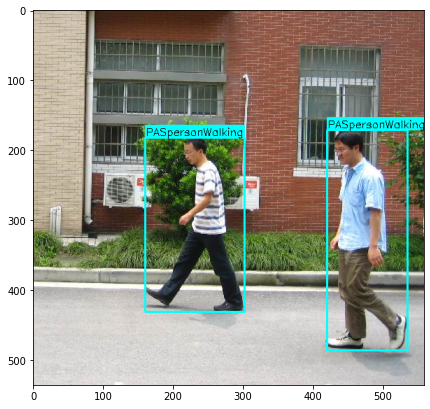

In [ ]:
_,ax = plt.subplots(1,1,figsize=(7,7))
show_record(image=image,
            boxes=target['boxes'].astype(np.int32),
            labels=labels,
            ax=ax)

# DataModule

In [ ]:
from hydra.experimental import initialize, compose
import hydra
from omegaconf import OmegaConf, DictConfig
from hydra.core.global_hydra import GlobalHydra

In [ ]:
# Global Initialization
GlobalHydra.instance().clear()
initialize(config_path="conf")
cfg = compose("config")

In [ ]:
print(OmegaConf.to_yaml(cfg))

data:
  csv_path: data_with_folds.csv
  valid_fold: 2
  num_workers: 4
  batch_size: 12
aug:
  tfms:
    hue_sat:
      _target_: albumentations.augmentations.transforms.HueSaturationValue
      hue_shift_limit: 0.2
      sat_shift_limit: 0.2
      val_shift_limit: 0.2
      p: 0.9
    brightness_contrast:
      _target_: albumentations.augmentations.transforms.RandomBrightnessContrast
      brightness_limit: 0.2
      contrast_limit: 0.2
      p: 0.9
    to_gray:
      _target_: albumentations.augmentations.transforms.ToGray
      p: 0.01
    horizontal_flip:
      _target_: albumentations.augmentations.transforms.HorizontalFlip
      p: 0.5
    vertical_flip:
      _target_: albumentations.augmentations.transforms.VerticalFlip
      p: 0.5
    coarse_dropout:
      _target_: albumentations.augmentations.transforms.CoarseDropout
      min_holes: 8
      max_height: 16
      max_width: 16
      fill_value: 0
      p: 0.5
    to_tensor:
      _target_: albumentations.pytorch.transforms.

In [ ]:
datamodule = PennFudanDataModule(cfg=cfg,
                                 train_transforms=TrainTransforms(cfg.aug),
                                 val_transforms=ValTransforms(cfg.aug))
datamodule.setup(stage='fit')
train_loader = datamodule.train_dataloader()

In [ ]:
try: del images,targets,image_ids
except: pass

In [ ]:
images,targets,image_ids = next(iter(train_loader))

In [ ]:
idx_to_label = {v:k for k,v in train_loader.dataset.class_to_idx.items()}; idx_to_label

def LabelMapper(idx_to_label):
    def mapper(x): 
        if isinstance(x,torch.Tensor):
            x = x.item()
        return idx_to_label[x]
    return mapper

label_mapper = LabelMapper(idx_to_label)

In [ ]:
idx = 6
image = to_numpy(images[idx],permute=True)
target = targets[idx]
boxes = to_numpy(target['boxes']).astype(np.int32)
labels = list(map(label_mapper, target['labels']))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


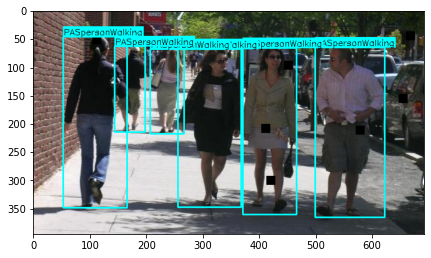

In [ ]:
_,ax = plt.subplots(1,1,figsize=(7,7))
show_record(image=image,
            boxes=boxes,
            labels=labels,
            ax=ax)